In [71]:
# imports
import math
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sys
import random
import scipy.optimize as opt
from scipy import stats
#!pip install torch
import torch

random.seed(19680801)
np.random.seed(19680801)
torch.manual_seed(19680801)
torch.cuda.manual_seed(19680801)
torch.backends.cudnn.deterministic = True

# Task #3 "Algorithms for unconstrained nonlinear optimization. First- and second- order methods”

# Goal

### The use of first- and second-order methods (Gradient Descent, Non-linear Conjugate Gradient Descent, Newton’s method and Levenberg-Marquardt algorithm) in the tasks of unconstrained nonlinear optimization

# Results

## Generating data and run part code of Lab2

In [124]:
a = random.random()
b = random.random()

print(a, b)

0.3618608486370415 0.6591393382613565


In [125]:
x = np.linspace(0, 101, 101) / 100
sigma = np.random.normal(0, 0.1, 101)

y = a * x + b + sigma

In [126]:
class Point:
  def __init__(self, x, y):
    self.x = x
    self.y = y

In [127]:
# brute-force for Gradient descent
def exhaustive_search(func, a, b, e = 0.001):
    optim_point = Point(math.inf, math.inf)

    n = int((b - a) / e)
    step = (b - a) / n

    for k in range(0, n):
        x_k = a + k * step
        y_k = func(x_k)

        if optim_point.y > y_k:
            optim_point = Point(x_k, y_k)

    iter_count = n
    f_calc_count = n

    return optim_point, iter_count, f_calc_count

## Defining loss functions for regression

In [128]:
def linear(x, a, b):
    return a * x + b

def rational(x, a, b):
    return a / (1 + b * x)

#Spesial version for loss to use in scipy optimisation
def loss_linear(z, *params):
    x, y = params
    a, b = z
    return np.sum((linear(x, a, b) - y)**2)

#Functional version for loss to calc precision
def f_loss_linear(x, y, a, b):
    return np.sum((linear(x, a, b) - y)**2)

#Spesial version for loss to use in scipy optimisation
def loss_rational(z, *params):
    x, y = params
    a, b = z
    return np.sum((rational(x, a, b) - y)**2)

#Functional version for loss to calc precision
def f_loss_rational(x, y, a, b):
    return np.sum((rational(x, a, b) - y)**2)

#Spesial version for loss to use in LMA method
def loss_linear_lma(z, *params):
    x, y = params
    a, b = z
    return (linear(x, a, b) - y)**2

#Spesial version for loss to use in LMA method
def loss_rational_lma(z, *params):
    x, y = params
    a, b = z
    return (rational(x, a, b) - y)**2

## Brute force method linear

In [129]:
brute_force = opt.brute(loss_linear, ([0,1],[0,1]), args=(x,y),  Ns = 1000, full_output=True)

brute_force_coafs = brute_force[0]
grid_size_x, grid_size_y = len(brute_force[2][0]), len(brute_force[2][0])
brute_froce_iter_count =  grid_size_x * grid_size_y
brute_force_f_calc_count = brute_froce_iter_count
brute_force_precision = f_loss_linear(x, y, brute_force_coafs[0], brute_force_coafs[1])

brute_force_result = [brute_froce_iter_count, brute_force_f_calc_count, brute_force_precision]

brute_force_result

[1000000, 1000000, 0.9426378535108151]

## Brute force method rational

In [130]:
brute_force_rational = opt.brute(loss_rational, ([0,1],[0,1]), args=(x,y),  Ns = 1000, full_output=True)

brute_force_coafs_rational = brute_force_rational[0]
grid_size_x, grid_size_y = len(brute_force_rational[2][0]), len(brute_force_rational[2][0])
brute_froce_iter_count_rational =  grid_size_x * grid_size_y
brute_force_f_calc_count_rational = brute_froce_iter_count_rational
brute_force_precision_rational = f_loss_rational(x, y, brute_force_coafs_rational[0], brute_force_coafs_rational[1])

brute_force_result_rational = [brute_froce_iter_count_rational,
                               brute_force_f_calc_count_rational,
                               brute_force_precision_rational]

brute_force_result_rational

[1000000, 1000000, 0.9671247672170838]

## Coordinate descent method

In [131]:
def get_loss_func(fix_coord, loss_type, coefs):
    if loss_type == 'rational':
        func = rational
    if loss_type == 'linear':
        func = linear

    if fix_coord == 'a':
        return lambda a: np.sum((func(x, a, coefs[1]) - y)**2)
    if fix_coord == 'b':
        return lambda b: np.sum((func(x, coefs[0], b) - y)**2)

def coordinate_descent(params, limits, loss_type, e=0.00001):
    dims = len(params)
    coefs = np.random.randn(dims) * 100
    min_loss_value = Point(float('inf'), float('inf'))
    iter_sum = 0
    func_calc_sum = 0

    while True:
        L = get_loss_func('a', loss_type, coefs)
        optim_point, iter_count, f_calc_count = exhaustive_search(L, *limits[0])
        coefs[0] = optim_point.x

        iter_sum += iter_count
        func_calc_sum += f_calc_count

        L = get_loss_func('b', loss_type, coefs)
        optim_point, iter_count, f_calc_count = exhaustive_search(L, *limits[1])
        coefs[1] = optim_point.x

        iter_sum += iter_count
        func_calc_sum += f_calc_count

        if abs(min_loss_value.x - optim_point.x) <= e and abs(min_loss_value.y - optim_point.y) <= e:
            break
        else:
            min_loss_value = optim_point

    return coefs, iter_sum, func_calc_sum

## Coordinate descent linear

In [132]:
coord_descent_coefs,\
coord_descent_iter_sum,\
coord_descent_func_calc_sum = coordinate_descent((x, y), ((-1,1),(-1,1)),loss_type='linear')
coord_descent_precision = f_loss_linear(x, y, coord_descent_coefs[0], coord_descent_coefs[1])

coordinate_descent_result = [coord_descent_iter_sum, coord_descent_func_calc_sum, coord_descent_precision]

## Coordinate descent rational

In [133]:
coord_descent_coefs_rational,\
coord_descent_iter_sum_rational,\
coord_descent_func_calc_sum_rational = coordinate_descent((x, y), ((-1,1),(-1,1)), loss_type='rational')
coord_descent_precision_rational = f_loss_rational(x, y, coord_descent_coefs[0], coord_descent_coefs[1])

coordinate_descent_result_rational = [coord_descent_iter_sum, coord_descent_func_calc_sum, coord_descent_precision]

## Nelder-Mead linear

In [134]:
initial_guess = [0, 0]
nelder_mead = opt.minimize(loss_linear, initial_guess, args=(x,y), method='Nelder-Mead', tol = 0.001)

nelder_mead_result = [nelder_mead['nit'], nelder_mead['nfev'], nelder_mead['fun']]

## Nelder-Mead rational

In [135]:
initial_guess = [0, 0]
nelder_mead_rational = opt.minimize(loss_rational, initial_guess, args=(x,y), method='Nelder-Mead', tol = 0.001)

nelder_mead_result_rational = [nelder_mead_rational['nit'], nelder_mead_rational['nfev'], nelder_mead_rational['fun']]

# Part of new methods

## Gradient descent linear

In [204]:
class RegressionModel(torch.nn.Module):
    def __init__(self, reg_func):

        super().__init__()
        self.reg_func = reg_func
        self.a = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))

    def forward(self, x):
        return self.reg_func(x, self.a, self.b) #self.a / (1 +  self.b * x)

    def string(self):
        return f'y = {self.a.item()} / (1 + {self.b.item()} * x)'

    def get_coefs(self):
        return self.a.item(), self.b.item()


def SGD(x, y, reg_func, lr=0.001, epoch_count=2000, show_loss_graph=True):
    model = RegressionModel(reg_func)

    criterion = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    loss_list = []

    X = torch.from_numpy(x)
    Y = torch.from_numpy(y)

    y_min = float('inf')
    y_pred = float('inf')
    epoch_count = 0

    while True:
        epoch_count += 1

        y_pred = model(X)

        loss = criterion(y_pred, Y)
        loss_list.append(loss.item())


        if abs(y_min - loss.item()) < 0.001 and epoch_count % 10 == 0:
            break
        else:
            y_min = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if show_loss_graph:
        plt.plot(loss_list, 'r')
        plt.tight_layout()
        plt.grid()
        plt.xlabel("Epochs/Iterations")
        plt.ylabel("Loss")
        plt.show()

    iter_num = epoch_count
    func_calc_num = epoch_count
    precision = loss_list[len(loss_list)-1]
    return *model.get_coefs(), iter_num, func_calc_num, precision

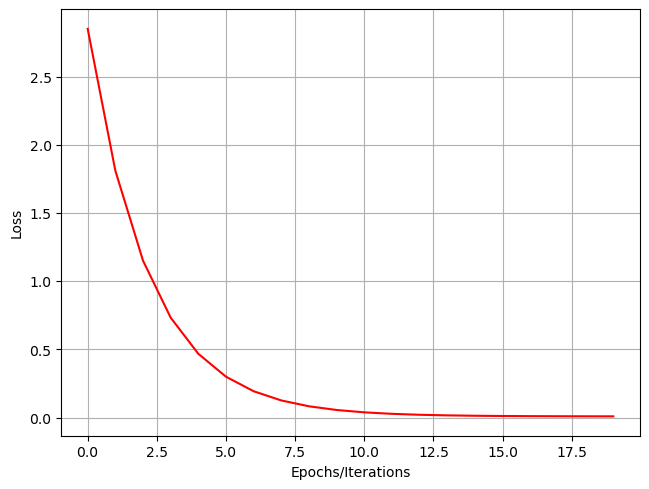

In [235]:
w, b, iter_num, func_calc_num, precision = SGD(x, y, linear, epoch_count=400, lr=0.08)
SGD_result_linear = [iter_num, func_calc_num, precision]

## Gradient descent rational

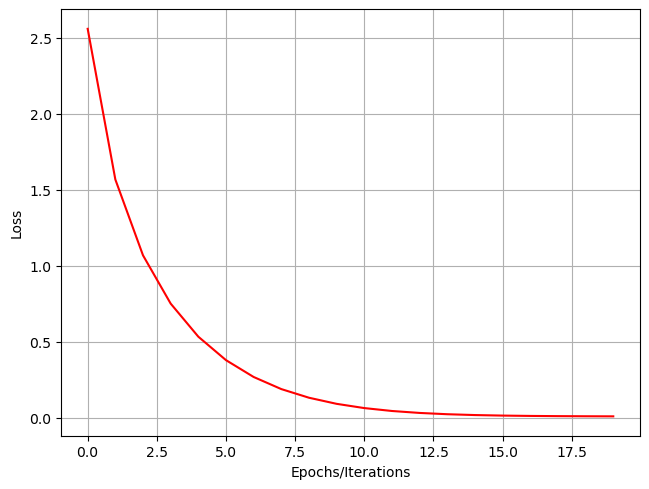

In [243]:
w_rational, b_rational, iter_num_rational, func_calc_num_rational, precision_rational = SGD(x, y, rational, epoch_count=400, lr=0.08)
SGD_result_rational = [iter_num_rational, func_calc_num_rational, precision_rational]

## Conjugate Gradient Descent linear

In [139]:
initial_guess = [0, 0]
conjugate_linear = opt.minimize(loss_linear, initial_guess, args=(x,y), method='CG', tol = 0.001)

conjugate_linear

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.9426378250669009
       x: [ 3.165e-01  6.758e-01]
     nit: 2
     jac: [ 2.682e-07  6.855e-07]
    nfev: 15
    njev: 5

In [140]:
conjugate_result_linear = [conjugate_linear['nit'], conjugate_linear['nfev'], conjugate_linear['fun']]

## Conjugate Gradient Descent rational

In [141]:
initial_guess = [0, 0]
conjugate_rational = opt.minimize(loss_rational, initial_guess, args=(x,y), method='CG', tol = 0.001)

conjugate_result_rational = [conjugate_rational['nit'], conjugate_rational['nfev'], conjugate_rational['fun']]

## Newton method linear

In [142]:
initial_guess = [0, 0]
newton_linear = opt.minimize(loss_linear, initial_guess, args=(x,y), method='BFGS', tol=0.001)

newton_result_linear = [newton_linear['nit'], newton_linear['nfev'], newton_linear['fun']]

## Newton method rational

In [143]:
initial_guess = [0, 0]
newton_rational = opt.minimize(loss_rational, initial_guess, args=(x,y), method='BFGS', tol=0.001)

newton_result_rational = [newton_rational['nit'], newton_rational['nfev'], newton_rational['fun']]

## Levenberg-Marquardt algorithm linear

In [144]:
initial_guess = [0, 0]
lma_linear = opt.least_squares(loss_linear_lma, initial_guess, args=(x,y), method='lm')

lma_linear

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 6.344e-03  1.298e-03 ...  1.102e-03  5.928e-04]
           x: [ 2.941e-01  6.769e-01]
        cost: 0.012541158037705879
         jac: [[ 0.000e+00  1.593e-01]
               [ 7.278e-04  7.206e-02]
               ...
               [ 6.638e-02  6.638e-02]
               [-4.918e-02 -4.869e-02]]
        grad: [-4.889e-06 -8.685e-06]
  optimality: 8.68454814725322e-06
 active_mask: [0 0]
        nfev: 52
        njev: None

In [145]:
lma_result_linear = [len(lma_linear['fun']), lma_linear['nfev'], lma_linear['cost']]

## Levenberg-Marquardt algorithm rational

In [146]:
initial_guess = [0, 0]
lma_rational = opt.least_squares(loss_rational_lma, initial_guess, args=(x,y), method='lm')

lma_result_rational = [len(lma_rational['fun']), lma_rational['nfev'], lma_rational['cost']]

## Plotting the result

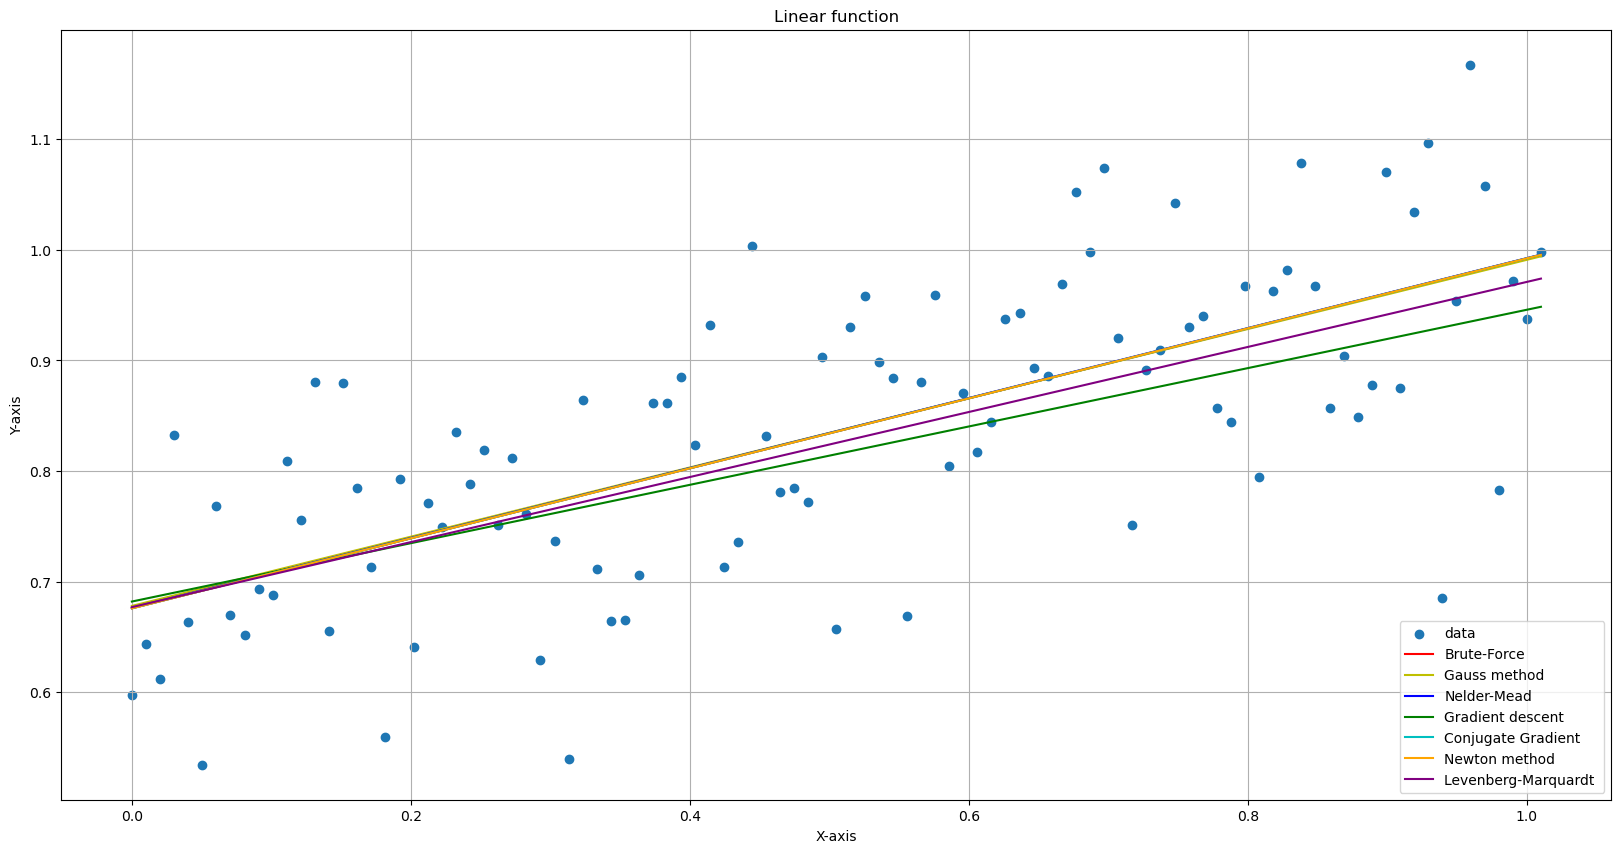

In [238]:
#linear
plt.figure(figsize = (20, 10))

plt.scatter(x, y, label = 'data')
plt.plot(x, linear(x, brute_force_coafs[0], brute_force_coafs[1] ), label='Brute-Force', color = 'r')
plt.plot(x, linear(x, coord_descent_coefs[0], coord_descent_coefs[1] ), label='Gauss method', color = 'y')
plt.plot(x, linear(x, nelder_mead['x'][0], nelder_mead['x'][1]), label='Nelder-Mead', color = 'b')
plt.plot(x, linear(x, w, b), label='Gradient descent', color = 'g')
plt.plot(x, linear(x, conjugate_linear['x'][0], conjugate_linear['x'][1]), label='Сonjugate Gradient', color = 'c')
plt.plot(x, linear(x, newton_linear['x'][0], newton_linear['x'][1]), label='Newton method', color = 'orange')
plt.plot(x, linear(x, lma_linear['x'][0], lma_linear['x'][1]), label='Levenberg-Marquardt ', color = 'purple')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Linear function')
plt.legend(loc='lower right')
plt.grid()

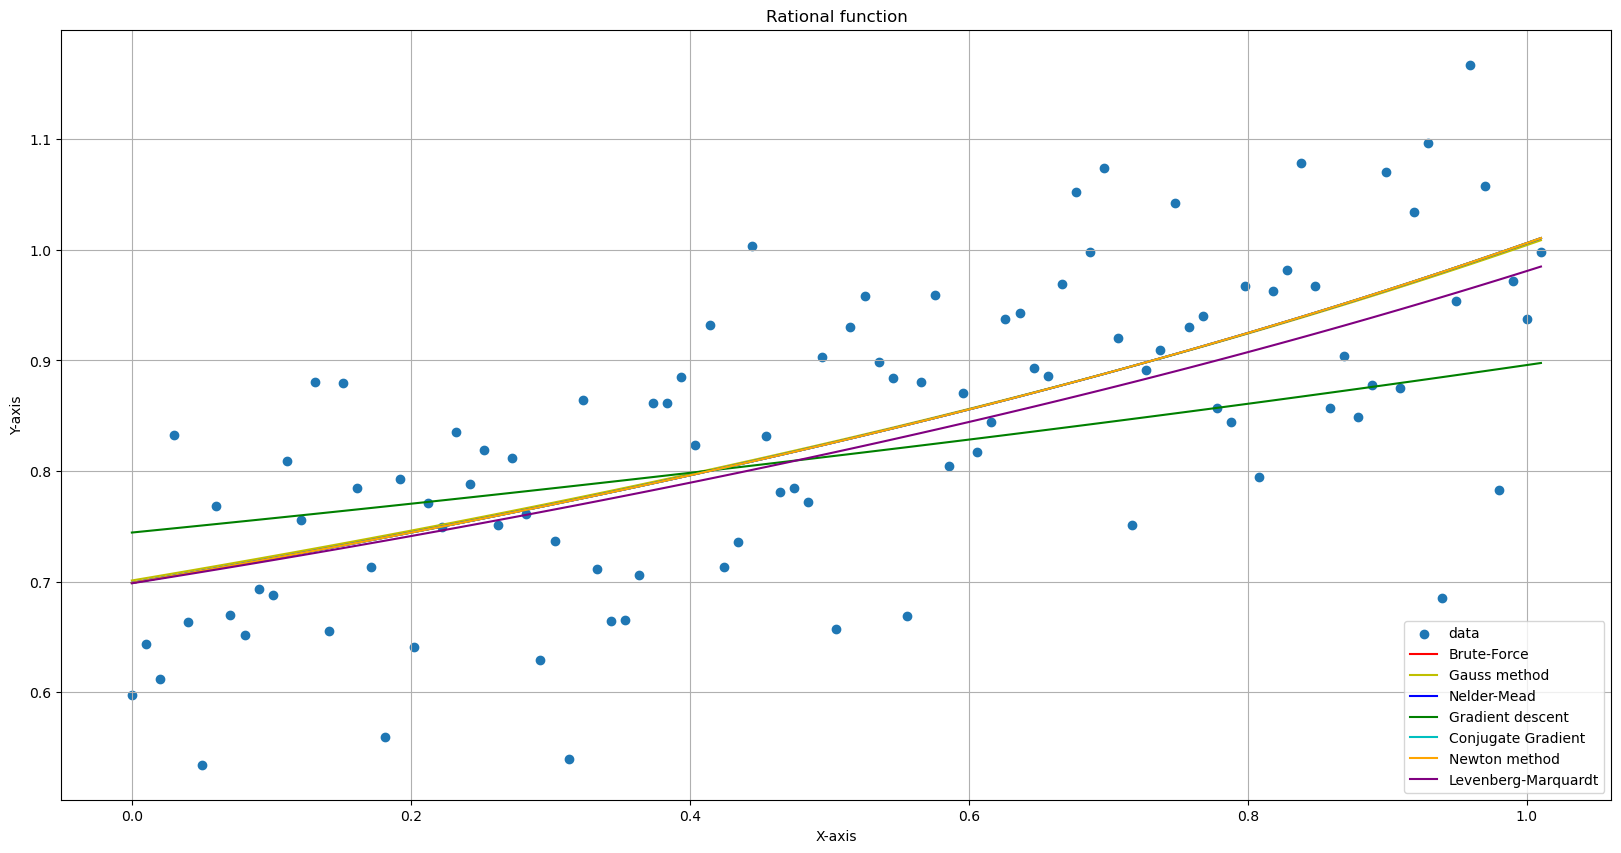

In [244]:
#rational
plt.figure(figsize = (20, 10))

plt.scatter(x, y, label = 'data')
plt.plot(x, rational(x, brute_force_coafs_rational[0], brute_force_coafs_rational[1] ), label='Brute-Force', color = 'r')
plt.plot(x, rational(x, coord_descent_coefs_rational[0], coord_descent_coefs_rational[1] ), label='Gauss method', color = 'y')
plt.plot(x, rational(x, nelder_mead_rational['x'][0], nelder_mead_rational['x'][1]), label='Nelder-Mead', color = 'b')
plt.plot(x, rational(x, w_rational, b_rational), label='Gradient descent', color = 'g')
plt.plot(x, rational(x, conjugate_rational['x'][0], conjugate_rational['x'][1]), label='Сonjugate Gradient', color = 'c')
plt.plot(x, rational(x, newton_rational['x'][0], newton_rational['x'][1]), label='Newton method', color = 'orange')
plt.plot(x, rational(x, lma_rational['x'][0], lma_rational['x'][1]), label='Levenberg-Marquardt', color = 'purple')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Rational function')
plt.legend(loc='lower right')
plt.grid()

In [245]:
#dataframe
df_linear = pd.DataFrame([brute_force_result, coordinate_descent_result, nelder_mead_result,
                                   SGD_result_linear, conjugate_result_linear, newton_result_linear, lma_result_linear],
                         columns=['iter_count', 'f_calc_count', 'precision'],
                         index = ["Brute force", "Coordinate Gradient", "Nelder-Mead", "Gradient Descent",
                                  "Сonjugate Gradient Descent ", "Newton method", "Levenberg-Marquardt algorithm"])
df_rational = pd.DataFrame([brute_force_result_rational, coordinate_descent_result_rational, nelder_mead_result_rational,
                                   SGD_result_rational, conjugate_result_rational, newton_result_rational, lma_result_rational],
                         columns=['iter_count', 'f_calc_count', 'precision'],
                         index = ["Brute force", "Coordinate Gradient", "Nelder-Mead", "Gradient Descent",
                                  "Сonjugate Gradient Descent ", "Newton method", "Levenberg-Marquardt algorithm"])

In [246]:
df_linear

,iter_count,f_calc_count,precision
Brute force,1000000,1000000,0.942638
Coordinate Gradient,84000,84000,0.942762
Nelder-Mead,51,98,0.942648
Gradient Descent,20,20,0.009990
Сonjugate Gradient Descent,2,15,0.942638
Newton method,5,21,0.942638
Levenberg-Marquardt algorithm,101,52,0.012541


In [247]:
df_rational

,iter_count,f_calc_count,precision
Brute force,1000000,1000000,0.967125
Coordinate Gradient,84000,84000,0.942762
Nelder-Mead,55,107,0.967125
Gradient Descent,20,20,0.012117
Сonjugate Gradient Descent,9,57,0.967125
Newton method,9,39,0.967125
Levenberg-Marquardt algorithm,101,49,0.013031


# Conclusion

### In this practical work was considered the use of first- and second-order methods (Gradient Descent, Non-linear Conjugate Gradient Descent, Newton’s method and Levenberg-Marquardt algorithm) in the tasks of unconstrained nonlinear optimization. The obtained results show us the advantages of second-order methods, for example, Newton’s method which has the lowest value of iterations and f-calculations with each type of functions.